<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20I%20%3A%20Methods%20%26%20Technologies%20for%20Business%20Analytics/Chapter%205%3A%20Neural%20Networks%20and%20Deep%20Learning/5_3_Recurrent_Neural_Networks_%26_Sequential_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Networks and Deep Learning**
## Recurrent Neural Networks & Sequential Modelling

### **Example: Power Consumption Forecast**

In [ ]:
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MinMaxScaler

#Install tensorflow if not 
#!pip install tensorflow==2.2

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout, Activation

In [ ]:
# Import Data  
url=   'https://drive.google.com/file/d/1FJyED9Rh6UHDFvcY1YxHzGn5TqSq3kzu/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path,sep=";")
df.set_index(['Date','Time'], inplace=True)
df.head()

Global_active_power  ... Sub_metering_3
Date       Time                          ...               
16/12/2006 17:24:00               4.216  ...           17.0
           17:25:00               5.360  ...           16.0
           17:26:00               5.374  ...           17.0
           17:27:00               5.388  ...           17.0
           17:28:00               3.666  ...           17.0

[5 rows x 7 columns]

## Dataset Information
Variable Name | Variable Description
-------------------|------------------
Global_active_power	| The total active power consumed by the household (kilowatts)
Global_reactive_power | The total reactive power consumed by the household (kilowatts)
Voltage | Minute-averaged voltage (volts)
Global_intensity | Household global minute-averaged current intensity (amperes)
Sub_metering_1 | Active energy for kitchen (watt-hours of active energy)
Sub_metering_2 | Active energy for laundry (watt-hours of active energy)
Sub_metering_3 | Active energy for climate control systems (watt-hours of active energy)

## Data Preprocessing

Missing values given '?' are changed to nan and variables are converted to numeric type

In [ ]:
df.replace('?', np.nan, inplace=True)
cols = df.select_dtypes(exclude=['float']).columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float64
dtype: object

Next, remaning watt-hours are calculating

In [ ]:
df['sub_metering_4'] = (df['Global_active_power'] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_2'])

The target variable is created to predict the next minute

In [ ]:
df['Global_active_power_Next'] = df['Global_active_power'].shift(1)
df.dropna(inplace=True)

In [ ]:
X = df.drop(columns=['Global_active_power_Next'])
y = df[['Global_active_power_Next']]

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_size, test_size

(7996, 2000)

In [ ]:
scaler_x = MinMaxScaler()
X_norm = scaler_x.fit_transform(X)
X_train, X_test = X_norm[:train_size], X_norm[train_size:]

y_true = y[train_size:]
scaler_y = MinMaxScaler()
y_norm = scaler_y.fit_transform(y)
y_train = y_norm[:train_size]

The values of the previous 2 minutes will be used to predict the next minute

In [ ]:
lookback=2
train_size = train_size - lookback + 1

Preparing data for the LSTM method

In [ ]:
X_all=[]
y_all=[]
for i in range(len(X_norm)-lookback + 1):
    t=[]
    for j in range(0,lookback):
        t.append(X_norm[[(i+j)]])
    X_all.append(t)
    y_all.append(y_norm[i+ lookback - 1])

X_all, y_all= np.array(X_all), np.array(y_all)

y_pred=[]

X_train= X_all[:train_size]
X_test = X_all[train_size:train_size + test_size]
if lookback!=0:
    X_train = X_train.reshape(X_train.shape[0],lookback, X_train.shape[3])
    X_test = X_test.reshape(X_test.shape[0],lookback, X_test.shape[3])
else:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
    
y_train= y_all[:train_size]
y_test= y_all[train_size:]

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7995, 2, 8), (2000, 2, 8), (7995, 1), (2000, 1))

## LSTM Multivariate Time Series Regression

In [ ]:
units=4
epochs=100
batch_size=144

In [ ]:
from matplotlib import pyplot

Epoch 1/100
56/56 [==============================] - 3s 10ms/step - loss: 0.2518 - mae: 0.2518 - val_loss: 0.2728 - val_mae: 0.2728
Epoch 2/100
56/56 [==============================] - 0s 4ms/step - loss: 0.1741 - mae: 0.1741 - val_loss: 0.1994 - val_mae: 0.1994
Epoch 3/100
56/56 [==============================] - 0s 4ms/step - loss: 0.1365 - mae: 0.1365 - val_loss: 0.1530 - val_mae: 0.1530
Epoch 4/100
56/56 [==============================] - 0s 4ms/step - loss: 0.1084 - mae: 0.1084 - val_loss: 0.1172 - val_mae: 0.1172
Epoch 5/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0858 - mae: 0.0858 - val_loss: 0.0958 - val_mae: 0.0958
Epoch 6/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0735 - mae: 0.0735 - val_loss: 0.0862 - val_mae: 0.0862
Epoch 7/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0694 - mae: 0.0694 - val_loss: 0.0833 - val_mae: 0.0833
Epoch 8/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0667 - 

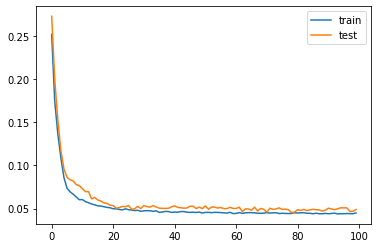

In [ ]:
np.random.seed(1)

K.clear_session()

## LSTM Model & Prediction ###############
model = Sequential()

model.add(LSTM(units=units, input_shape=(lookback,X_all.shape[3]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
    
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

y_pred= model.predict(X_test)

##########################################
        
y_pred = np.array(y_pred).reshape(test_size,1)
y_pred = scaler_y.inverse_transform(y_pred)

## Performance Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y_pred,y_true)

0.37695768

LSTM results are compared with multi layer perceptron method

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
X_train, X_test = X_norm[:train_size], X_norm[train_size:]
                
y_train = y_norm[:train_size]
y_true = y[train_size:]

### MLP

regressor = MLPRegressor(random_state=0,hidden_layer_sizes=(1,10))
regressor.fit(X_train, y_train.ravel())

y_pred = regressor.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred.reshape(y_pred.shape[0],1))

In [ ]:
mean_absolute_error(y_pred,y_true)

0.5375156040616599